In [154]:
'''
import modules 
'''

import pandas as pd 
import datetime
import pytz
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
def read_file(input_csv, timezone):
    '''
    This function will read in the input csv files and convert the UTC timezone to the desired timezone. 
    '''

    df = pd.read_csv(input_csv, parse_dates=['created']) #read in the file using the file path and parse the date column

    #depending on which csv is passed in, name the new timezone columns appropriately to make it easier for 
    #distinguishing later on when joining the tables

    if input_csv == 'orders.csv':
        df['order_date'] = df['created'].dt.tz_localize('UTC').dt.tz_convert(timezone)
    else:
        df['signup_date'] = df['created'].dt.tz_localize('UTC').dt.tz_convert(timezone)
        df['cohort_week'] = df['signup_date'].dt.to_period('W')

    df = df.drop(['created'], axis = 1) #drop the original created column 

    return df


In [156]:
orders_file_path = input("Enter path to the orders.csv file.")
customers_file_path = input("Enter path to the customers.csv file.")
timezone = input("Enter the desired timezone for the analysis - (NOT UTC)")

customers_df = read_file(customers_file_path, timezone)
orders_df = read_file(orders_file_path, timezone)

/Users/manpreetkaur/Library/Python/3.7/lib/python/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [157]:
customers_df.head()

,id,signup_date,cohort_week
0,35410,2015-07-03 15:01:11-07:00,2015-06-29/2015-07-05
1,35417,2015-07-03 15:11:23-07:00,2015-06-29/2015-07-05
2,35412,2015-07-03 15:02:52-07:00,2015-06-29/2015-07-05
3,35413,2015-07-03 15:05:02-07:00,2015-06-29/2015-07-05
4,35424,2015-07-03 15:21:55-07:00,2015-06-29/2015-07-05


In [158]:
orders_df.head()

,id,order_number,user_id,order_date
0,1709,36,344,2014-10-27 17:20:01-07:00
1,1406,7,608,2014-10-14 16:44:53-07:00
2,1716,6,2296,2014-10-28 10:47:07-07:00
3,1426,2,1225,2014-10-15 11:33:38-07:00
4,1415,6,797,2014-10-14 19:07:16-07:00


In [159]:
def convert_to_day_range(bucket):
    '''
    This function will find the day range for a bucket
    '''
    start = bucket * 7
    end = start + 6

    return f"{start}-{end}"

def get_range(bucket_map, value):
    ''' This function will use the bucket to day range dictionary and return the value given the key'''
    for key, day_range in bucket_map.items():
        if value == key:
            return day_range
    
def wrangle_data(customers_df, orders_df): 
    '''
    This function will return a joined dataframe between the orders and customers csv.
    It will also persofrm the following:
        1. Find the cohort week for the customers df and add that data as another column 
        2. Drop any Null values in the dataframes as a precaution 
        3. Rename some of the columns that were updated with suffixes from the join
        4. Sort the dataframe via the signup date for each customer 
        5. This function will also convert the timezone datetime column to a date column for readability purposes 
        6. Find the time lapsed between the signup date and the order date for each customer 
        7. Calculate the buckets in which the customers fall under
        8. Add a T/F column to indicate whether an order is first time order
        9. Add the day ranges for the corresponding buckets using the convert to day range function
    '''

    #perform the join between the two dataframe to find customers that were signedup AND placed an order. 
    df = pd.merge(customers_df, orders_df, left_on=['id'], right_on=['user_id'], how = 'left')

    #drop any null values in the joined DF
    df.dropna(how='any', inplace = True)
    
    #drop the duplicate user_id column 
    df = df.drop(['user_id'], axis=1)

    #rename the columns that were updates with suffixes for easier readability 
    df = df.rename({'id_x': 'user_id', 'id_y':'order_id'}, axis = 1)

    #sort the df with the signup 
    df.sort_values('signup_date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    #convert the datetimes to dates
    df['signup_date'] = df['signup_date'].dt.date
    df['order_date'] = df['order_date'].dt.date

    #find the number of days between the signup day and order date for each customer 
    df['days_since_signup'] = (df['order_date'] - df['signup_date']).dt.days

    #place each customer's order into a bucket
    df['bucket'] = df['days_since_signup'] // 7

    #check if the order is a first time order or not
    df['first_time'] = df['order_number'].apply(lambda x: False if x > 1 else True)

    #find the day range for the buckets 
    bucket_map = {bucket: convert_to_day_range(bucket) for bucket in range(0, 27)}
    df['day_range'] = df['bucket'].apply(lambda x: get_range(bucket_map, x))
    return df



In [160]:
customers_orders_df = wrangle_data(customers_df, orders_df)
customers_orders_df.head()

,user_id,signup_date,cohort_week,order_id,order_number,order_date,days_since_signup,bucket,first_time,day_range
0,9488,2014-12-31,2014-12-29/2015-01-04,3909.0,1.0,2014-12-31,0,0,True,0-6
1,9488,2014-12-31,2014-12-29/2015-01-04,4855.0,2.0,2015-01-14,14,2,False,14-20
2,9493,2014-12-31,2014-12-29/2015-01-04,6586.0,1.0,2015-01-31,31,4,True,28-34
3,9495,2014-12-31,2014-12-29/2015-01-04,16086.0,2.0,2015-04-20,110,15,False,105-111
4,9495,2014-12-31,2014-12-29/2015-01-04,12629.0,1.0,2015-03-23,82,11,True,77-83


In [161]:
def total_customers(customers_df):
    '''
    This function will return a dataframe of total customers that were signed up per cohort week. 
    This is different from the joined dataframe because there are more customers signed up that did not 
    place orders. 
    '''
    #group by the cohort week and count the unique number of user id's for each cohort week
    df = customers_df.groupby('cohort_week')['id'].nunique()
    df = df.reset_index()
    df.columns = ['cohort_week', 'total_customers_count']

    return df

In [162]:
cohort_total_customers_df = total_customers(customers_df)
cohort_total_customers_df.head()

,cohort_week,total_customers_count
0,2014-12-29/2015-01-04,177
1,2015-01-05/2015-01-11,1771
2,2015-01-12/2015-01-18,1170
3,2015-01-19/2015-01-25,1285
4,2015-01-26/2015-02-01,607


In [163]:
def first_time_orderers(customers_orders_df, cohort_total_customers_df):
    '''
    This function calculates the first time order percentages given the joined df.
    '''
    #create a subset df with only first time orderers
    df = customers_orders_df[customers_orders_df['first_time'] == True]

    #count the number of unique users that placed first time orders and group them by cohort week and day range
    df_cohort_analysis = customers_orders_df.groupby(['cohort_week', 'day_range'])['user_id'].nunique().reset_index()

    #merge the total customers df with the cohort analysis df to find the percentages
    df_cohort_analysis = pd.merge(df_cohort_analysis, cohort_total_customers_df, on='cohort_week')

    #add a percentage column that will be using in the final pivot table
    df_cohort_analysis['percentage_first_time'] = (df_cohort_analysis['user_id'] / df_cohort_analysis['total_customers_count'] * 100).round(1)
    return df_cohort_analysis

In [164]:
first_time_orderers_cohort_analysis = first_time_orderers(customers_orders_df, cohort_total_customers_df)
first_time_orderers_cohort_analysis.head()

,cohort_week,day_range,user_id,total_customers_count,percentage_first_time
0,2014-12-29/2015-01-04,0-6,21,177,11.9
1,2014-12-29/2015-01-04,105-111,7,177,4.0
2,2014-12-29/2015-01-04,112-118,3,177,1.7
3,2014-12-29/2015-01-04,119-125,5,177,2.8
4,2014-12-29/2015-01-04,126-132,10,177,5.6


In [165]:
def total_orders(customers_orders_df, cohort_total_customers_df):
    '''
    This function will find the total percentages of orders for each bucket - not just exclusive to first time orders
    '''
    #perform cohort analysis by grouping by the cohort week and the day range and counting the number of users for each week
    df_cohort_analysis = customers_orders_df.groupby(['cohort_week', 'day_range'])['user_id'].count().reset_index()

    #merge the dfs on the cohort week 
    df_cohort_analysis = pd.merge(df_cohort_analysis, cohort_total_customers_df, on = 'cohort_week')

    #find the percentage by dividing the order
    df_cohort_analysis['percentage_total'] = (df_cohort_analysis['user_id'] / df_cohort_analysis['total_customers_count'] * 100).round(1)
    return df_cohort_analysis



In [166]:
total_orders_cohort_analysis = total_orders(customers_orders_df, cohort_total_customers_df)
total_orders_cohort_analysis.head()

,cohort_week,day_range,user_id,total_customers_count,percentage_total
0,2014-12-29/2015-01-04,0-6,29,177,16.4
1,2014-12-29/2015-01-04,105-111,10,177,5.6
2,2014-12-29/2015-01-04,112-118,7,177,4.0
3,2014-12-29/2015-01-04,119-125,7,177,4.0
4,2014-12-29/2015-01-04,126-132,12,177,6.8


In [167]:
def sort_day_ranges(day_range):
    ''' Helper function to sort the day ranges appropriately '''
    start_day = int(day_range.split('-')[0])
    return start_day


def pivot_data(total_orders_cohort_analysis, first_time_orderers_cohort_analysis):
    ''' 
    This function will return a pivoted dataframe by merging the total order data and the first time data.
    '''
    #merge the data to provide both percentages
    combined_df = pd.merge(total_orders_cohort_analysis, first_time_orderers_cohort_analysis, on = ['cohort_week', 'day_range'], suffixes=('_total', '_first_time'))

    #pivot the data with the columns being the buckets and the rows are cohort weeks with two large buckets describing the totals vs the first time
    combined_pivot = combined_df.pivot_table(index='cohort_week', columns = 'day_range', values= ['percentage_total', 'percentage_first_time'])

    #sort the day ranges level by using the helper function to split on the first day
    combined_pivot = combined_pivot.sort_values(by="day_range", axis =1, key=lambda x: x.map(sort_day_ranges))

    return combined_pivot.reset_index()

In [168]:
cohort_analysis_pivoted_df = pivot_data(total_orders_cohort_analysis, first_time_orderers_cohort_analysis)
cohort_analysis_pivoted_df.head()

cohort_week percentage_first_time percentage_total  \
day_range                                          0-6              0-6   
0          2014-12-29/2015-01-04                  11.9             16.4   
1          2015-01-05/2015-01-11                   8.0              9.9   
2          2015-01-12/2015-01-18                  16.2             19.0   
3          2015-01-19/2015-01-25                  16.2             18.4   
4          2015-01-26/2015-02-01                  21.3             24.2   

          percentage_first_time percentage_total       percentage_first_time  \
day_range                  7-13             7-13 14-20                 14-20   
0                           7.3              7.9   5.1                   5.1   
1                           6.0              6.7   4.3                   3.7   
2                           8.2              9.8   7.3                   6.2   
3                           7.9              8.9   4.8                   4.4   
4                           7.2              9.1   9.1                   7.2   

          percentage_total percentage_first_time percentage_total  ...  \
day_range            21-27                 21-27            28-34  ...   
0                      4.5                   4.0              6.8  ...   
1                      4.7                   4.2              3.7  ...   
2                      6.0                   5.1              5.7  ...   
3                      5.6                   5.1              5.4  ...   
4                      5.9                   5.1              9.1  ...   

                  percentage_first_time         percentage_total  \
day_range 154-160               154-160 161-167          161-167   
0             1.7                   1.1     2.3              4.0   
1             3.2                   2.8     3.1              3.5   
2             3.8                   3.2     3.2              4.0   
3             3.0                   2.7     2.1              2.3   
4             6.1                   4.1     0.5              0.7   

          percentage_first_time percentage_total          \
day_range               168-174          168-174 175-181   
0                           2.8              4.0     1.7   
1                           2.0              2.2     1.6   
2                           2.8              3.5     0.2   
3                           0.2              0.2     NaN   
4                           NaN              NaN     NaN   

          percentage_first_time percentage_total percentage_first_time  
day_range               175-181          182-188               182-188  
0                           1.7              1.7                   1.1  
1                           1.6              NaN                   NaN  
2                           0.2              NaN                   NaN  
3                           NaN              NaN                   NaN  
4                           NaN              NaN                   NaN  

[5 rows x 55 columns]

In [169]:
def merge_cohort_total(cohort_analysis_pivoted_df, cohort_total_customers_df):
    '''
    This function will return a pivoted data frame that will also include the total customers. 
    '''
    #merge the data frames on the cohort week
    df = pd.merge(cohort_analysis_pivoted_df, cohort_total_customers_df, on = 'cohort_week')
    filtered_col = [col for col in df.columns if col[0] != 'cohort_week']
    df = df[filtered_col]

    #the following reorders the columns
    cols = df.columns.tolist()
    column_to_move = 'total_customers_count'
    new_position = 1
    cols.insert(new_position, cols.pop(cols.index(column_to_move)))
    df = df[cols]

    #becuase the multi-indexed columns were converted to tuples, i want to convert them back to a multiindex for readability purposes
    switched_columns = [(col[1], col[0]) if isinstance(col, tuple) else (col, "") for col in df.columns]
    multiindex_columns = pd.MultiIndex.from_tuples(switched_columns)
    df.columns = multiindex_columns
    df.to_csv('final_cohort_analysis.csv', index = False)
    return df 

In [170]:
final_pivot_data = merge_cohort_total(cohort_analysis_pivoted_df, cohort_total_customers_df)
final_pivot_data.head()

/Users/manpreetkaur/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  
/Users/manpreetkaur/Library/Python/3.7/lib/python/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


cohort_week total_customers_count                   0-6  \
                                               percentage_first_time   
0  2014-12-29/2015-01-04                   177                  11.9   
1  2015-01-05/2015-01-11                  1771                   8.0   
2  2015-01-12/2015-01-18                  1170                  16.2   
3  2015-01-19/2015-01-25                  1285                  16.2   
4  2015-01-26/2015-02-01                   607                  21.3   

                                    7-13                             14-20  \
  percentage_total percentage_first_time percentage_total percentage_total   
0             16.4                   7.3              7.9              5.1   
1              9.9                   6.0              6.7              4.3   
2             19.0                   8.2              9.8              7.3   
3             18.4                   7.9              8.9              4.8   
4             24.2                   7.2              9.1              9.1   

                                   21-27                        ...  \
  percentage_first_time percentage_total percentage_first_time  ...   
0                   5.1              4.5                   4.0  ...   
1                   3.7              4.7                   4.2  ...   
2                   6.2              6.0                   5.1  ...   
3                   4.4              5.6                   5.1  ...   
4                   7.2              5.9                   5.1  ...   

           154-160                                     161-167  \
  percentage_total percentage_first_time percentage_first_time   
0              1.7                   1.1                   2.3   
1              3.2                   2.8                   3.1   
2              3.8                   3.2                   3.2   
3              3.0                   2.7                   2.1   
4              6.1                   4.1                   0.5   

                                 168-174                           175-181  \
  percentage_total percentage_first_time percentage_total percentage_total   
0              4.0                   2.8              4.0              1.7   
1              3.5                   2.0              2.2              1.6   
2              4.0                   2.8              3.5              0.2   
3              2.3                   0.2              0.2              NaN   
4              0.7                   NaN              NaN              NaN   

                                 182-188                        
  percentage_first_time percentage_total percentage_first_time  
0                   1.7              1.7                   1.1  
1                   1.6              NaN                   NaN  
2                   0.2              NaN                   NaN  
3                   NaN              NaN                   NaN  
4                   NaN              NaN                   NaN  

[5 rows x 56 columns]

In [171]:
def string_to_bucket(value):
    '''Helper Function to covert day range back to buckets'''
    start, end = map(int, value.split('-')) # split on the hyphen
    bucket = start // 7 #same method as earlier in the wrangling funtion
    return bucket

def visualize_data(final_pivot_data):
    ''' This function will return a visualization of the data by first converting the day ranges 
    back to buckets for the purpose of readability and then it will return a heatmap of the total orders.'''
    #convert the first level column names to buckets by first changing them to string type and then passing them to the helper function
    new_level_0 = [str(col[0]) if isinstance(col[0], int) else col[0] for col in final_pivot_data.columns]

    #get the column names
    new_columns = list(zip(new_level_0, final_pivot_data.columns.get_level_values(1)))    

    #redo the indexing of the dataframe
    new_multiindex = pd.MultiIndex.from_tuples(new_columns)
    final_pivot_data.columns = new_multiindex

    plt.figure(figsize=(16,10))
    heatmap = sns.heatmap(final_pivot_data.xs('percentage_total', axis=1, level=1), cmap="YlGnBu", annot=True, fmt='.0f', cbar_kws={'label': ' % Total Orders'})
    heatmap.set_yticklabels(final_pivot_data['cohort_week'], rotation=0)
    plt.xlabel('Bucket')
    plt.ylabel('Cohort Week')
    plt.title('Cohort Analysis: Total Orders')
    plt.savefig("total_orders_cohort_analysis.png", dpi = 300)
    plt.show()

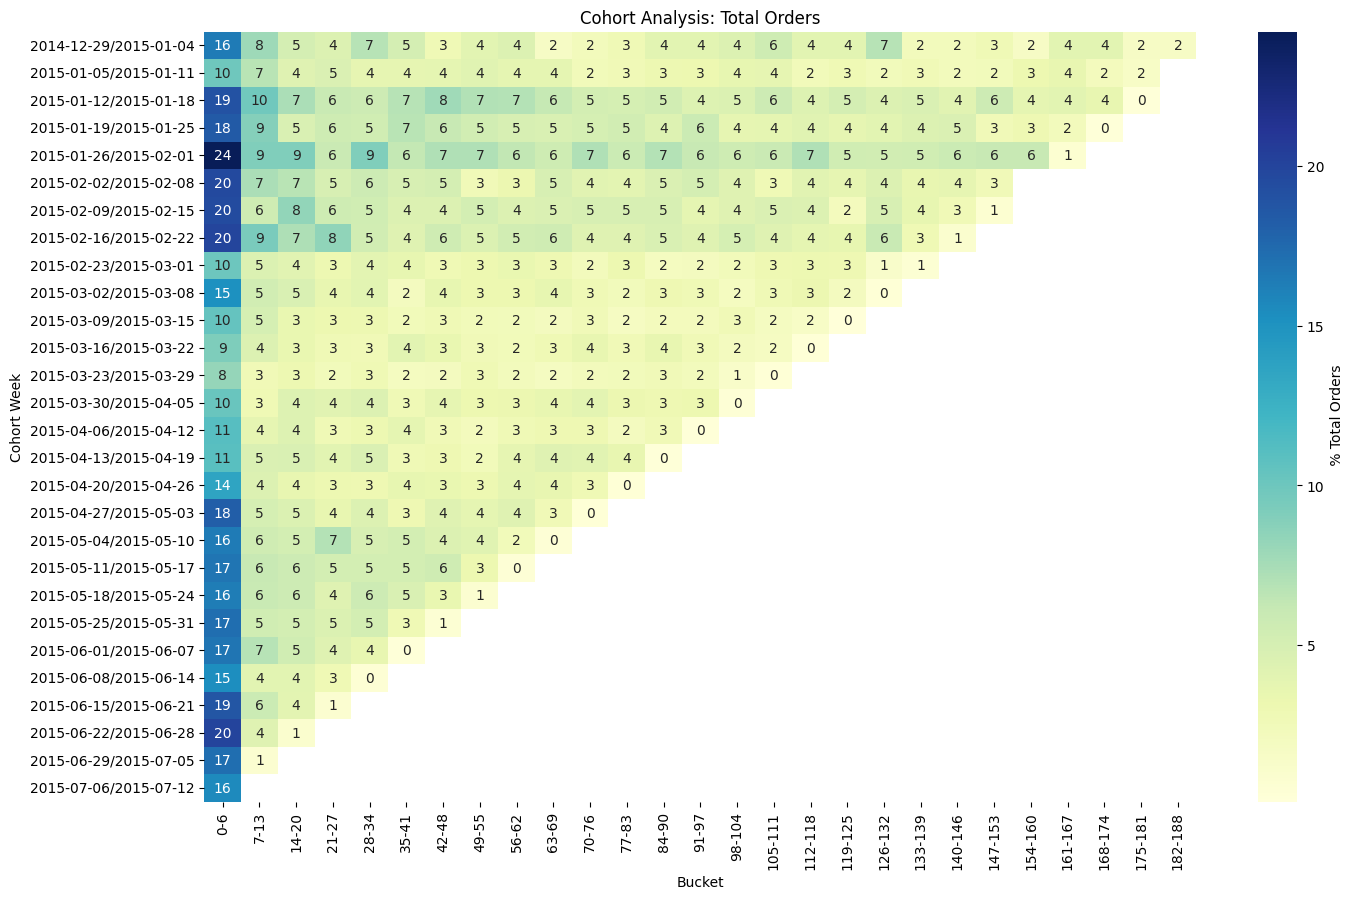

In [172]:
visual = visualize_data(final_pivot_data)
visual